# Mojito Processing Pipeline

Demonstrates the full TDI data processing pipeline using the `process_pipeline` utility from `MojitoProcessor`.

The pipeline applies the following steps in order:

| Step | Operation | Default |
|------|-----------|------|
| 1 | Band-pass filter | configurable (f_low, f_high), order |
| 2 | Trim edge artefacts | 2.2% from each end |
| 3 | Truncate to working length | configurable |
| 4 | Downsample | configurable target rate |
| 5 | Tukey window | α = 0.025 |

The final cell verifies consistency by comparing the periodogram against the Mojito L1 noise estimate.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from MojitoProcessor import load_mojito_l1, process_pipeline

# Show pipeline progress at INFO level
logging.basicConfig(
    level=logging.INFO,
    format="%(name)s | %(message)s",
)

## 1. Load Data

In [2]:
mojito_data_file = (
    "../../Mojito_Data/NOISE_731d_0.25s_L1_source0_0_20251206T220508924302Z.h5"
)

# Load in the data file
data = load_mojito_l1(mojito_data_file)


print(
    f"Loaded: {data.n_samples:,} samples @ {data.fs} Hz ({data.duration/86400:.2f} days)"
)
print(f"Channels: {list(data.tdis.keys())}")

Loading: ../../Mojito_Data/NOISE_731d_0.25s_L1_source0_0_20251206T220508924302Z.h5
File size: 34701.86 MB

Metadata:
  Pipeline: mojito-noise-simple-total-extended-total
  Laser frequency: 2.816e+14 Hz

TDI Sampling:
  t0 = 97729889.328 s (TCB)
  fs = 4.000 Hz, dt = 0.250 s
  Duration: 63116300.0 s (730.51 days)
  Samples: 252,465,200
  ✓ Loaded TDI-X: shape=(252465200,)
  ✓ Loaded TDI-Y: shape=(252465200,)
  ✓ Loaded TDI-Z: shape=(252465200,)
  ✓ Loaded TDI-A: shape=(252465200,)
  ✓ Loaded TDI-E: shape=(252465200,)
  ✓ Loaded TDI-T: shape=(252465200,)

Pre-computed Noise Estimates:
  Frequency range: 1.00e-05 to 1.00e+00 Hz
  Frequency bins: 1000
  XYZ covariance: 731 segments x 1000 freqs x 3x3
  AET covariance: (731, 1000, 3, 3)

✓ Successfully loaded mojito data
Loaded: 252,465,200 samples @ 4.0 Hz (730.51 days)
Channels: ['X', 'Y', 'Z', 'A', 'E', 'T']


## 2. Run the Processing Pipeline

All pipeline parameters are configurable here. The pipeline runs in this order:

```
bandpass/highpass filter → downsample → trim → truncate → window
```

In [3]:
# ── Pipeline parameters ───────────────────────────────────────────────────────

# Downsampling parameters
downsample_kwargs = {
    "target_fs": 0.2,  # Hz — target sampling rate (None = no downsampling).
    "kaiser_window": 31.0,  # Kaiser window beta parameter (higher = more aggressive anti-aliasing)
}

# Filter parameters
filter_kwargs = {
    "highpass_cutoff": 5e-6,  # Hz — high-pass cutoff (always applied)
    "lowpass_cutoff": 0.8
    * downsample_kwargs[
        "target_fs"
    ],  # Hz — low-pass cutoff (set None for high-pass only)
    "order": 2,  # Butterworth filter order
}

# Trim parameters
trim_kwargs = {
    "fraction": 0.02,  # Fraction of post-downsample duration trimmed from each end.
    # Total amount of data remaining is (1 - fraction) * N, for N
    # the number of samples after downsampling.
}

# Segmentation parameters
truncate_kwargs = {
    "days": 7.0,  # Segment length in days (splits dataset into 7-day chunks)
}

# Window parameters
window_kwargs = {
    "window": "tukey",  # Window type: 'tukey', 'hann', 'hamming', 'blackman'
    "alpha": 0.0125,  # Taper fraction for Tukey window
}
# ─────────────────────────────────────────────────────────────────────────────

processed_segments = process_pipeline(
    data,
    downsample_kwargs=downsample_kwargs,
    filter_kwargs=filter_kwargs,
    trim_kwargs=trim_kwargs,
    truncate_kwargs=truncate_kwargs,
    window_kwargs=window_kwargs,
)

# For the rest of the notebook, use the first segment
sp_0 = processed_segments["segment0"]

MojitoProcessor.SigProcessing | lowpass_cutoff (0.16 Hz) exceeds Nyquist of target_fs (0.1 Hz). Frequencies above 0.1 Hz will be aliased after downsampling. Consider setting lowpass_cutoff <= 0.1 Hz.
MojitoProcessor.SigProcessing | Step 1/5 | Init: 252465200 samples @ 4 Hz (730.51 days), channels=['X', 'Y', 'Z']
MojitoProcessor.SigProcessing | Step 2/5 | Band-pass: [5.0e-06, 1.6e-01] Hz, order=2 (zero-phase Butterworth)
MojitoProcessor.SigProcessing | Step 3/5 | Resample: 4 Hz → 0.2 Hz, 252465200 → 12623260 samples (Nyquist = 0.1 Hz)
MojitoProcessor.SigProcessing | Step 4/5 | Trim: 0.02% from each end → 12370796 samples (715.90 days)
MojitoProcessor.SigProcessing | Step 5/5 | Segment: created 102 segments × 7.00 days each | Window: tukey (alpha=0.0125)


## 3. Compute FFT and Periodogram

The one-sided periodogram estimate of the noise Power Spectral Density $S$ is

$$\hat{S}(f_k) = \frac{2\,\Delta t}{N} \left|\tilde{n}(f_k)\right|^2$$

where $\tilde{n}$ is the FFT of the processed time series, $\Delta t$ the sampling interval and $N$ the length of the truncated data set.

In [6]:
# Convert from frequency to fractional frequency
CENTRAL_FREQ = data.metadata["laser_frequency"]

freq = np.fft.rfftfreq(sp_0.N, d=sp_0.dt)
fft_xyz = {ch: np.fft.rfft(sp_0.data[ch]) / CENTRAL_FREQ for ch in sp_0.channels}

# XYZ → AET
fft_aet = {
    "A": (fft_xyz["Z"] - fft_xyz["X"]) / np.sqrt(2),
    "E": (fft_xyz["X"] - 2 * fft_xyz["Y"] + fft_xyz["Z"]) / np.sqrt(6),
    "T": (fft_xyz["X"] + fft_xyz["Y"] + fft_xyz["Z"]) / np.sqrt(3),
}

# One-sided periodogram  S_hat(f) = 2*dt/N * |X(f)|^2
psd_norm = 2 * sp_0.dt / sp_0.N
pgram_xyz = {ch: psd_norm * np.abs(fft_xyz[ch]) ** 2 for ch in sp_0.channels}
pgram_aet = {ch: psd_norm * np.abs(fft_aet[ch]) ** 2 for ch in ["A", "E", "T"]}

# Mojito L1 noise estimate (segment 0 diagonal = auto-PSD)
l1_xyz = {
    ch: data.noise_cov_xyz[0][:, i, i] / CENTRAL_FREQ**2
    for i, ch in enumerate(["X", "Y", "Z"])
}
l1_aet = {
    ch: data.noise_cov_aet[0][:, i, i] / CENTRAL_FREQ**2
    for i, ch in enumerate(["A", "E", "T"])
}

## 4. Periodogram vs Mojito L1 Estimate

A good processing pipeline produces a periodogram (coloured lines) that traces the Mojito L1 noise model (red dashed) throughout the science band (1×10⁻⁴ to 1×10⁻¹ Hz). Potential deviations at the lowest frequencies indicate residual artefacts from filtering or insufficient trimming.

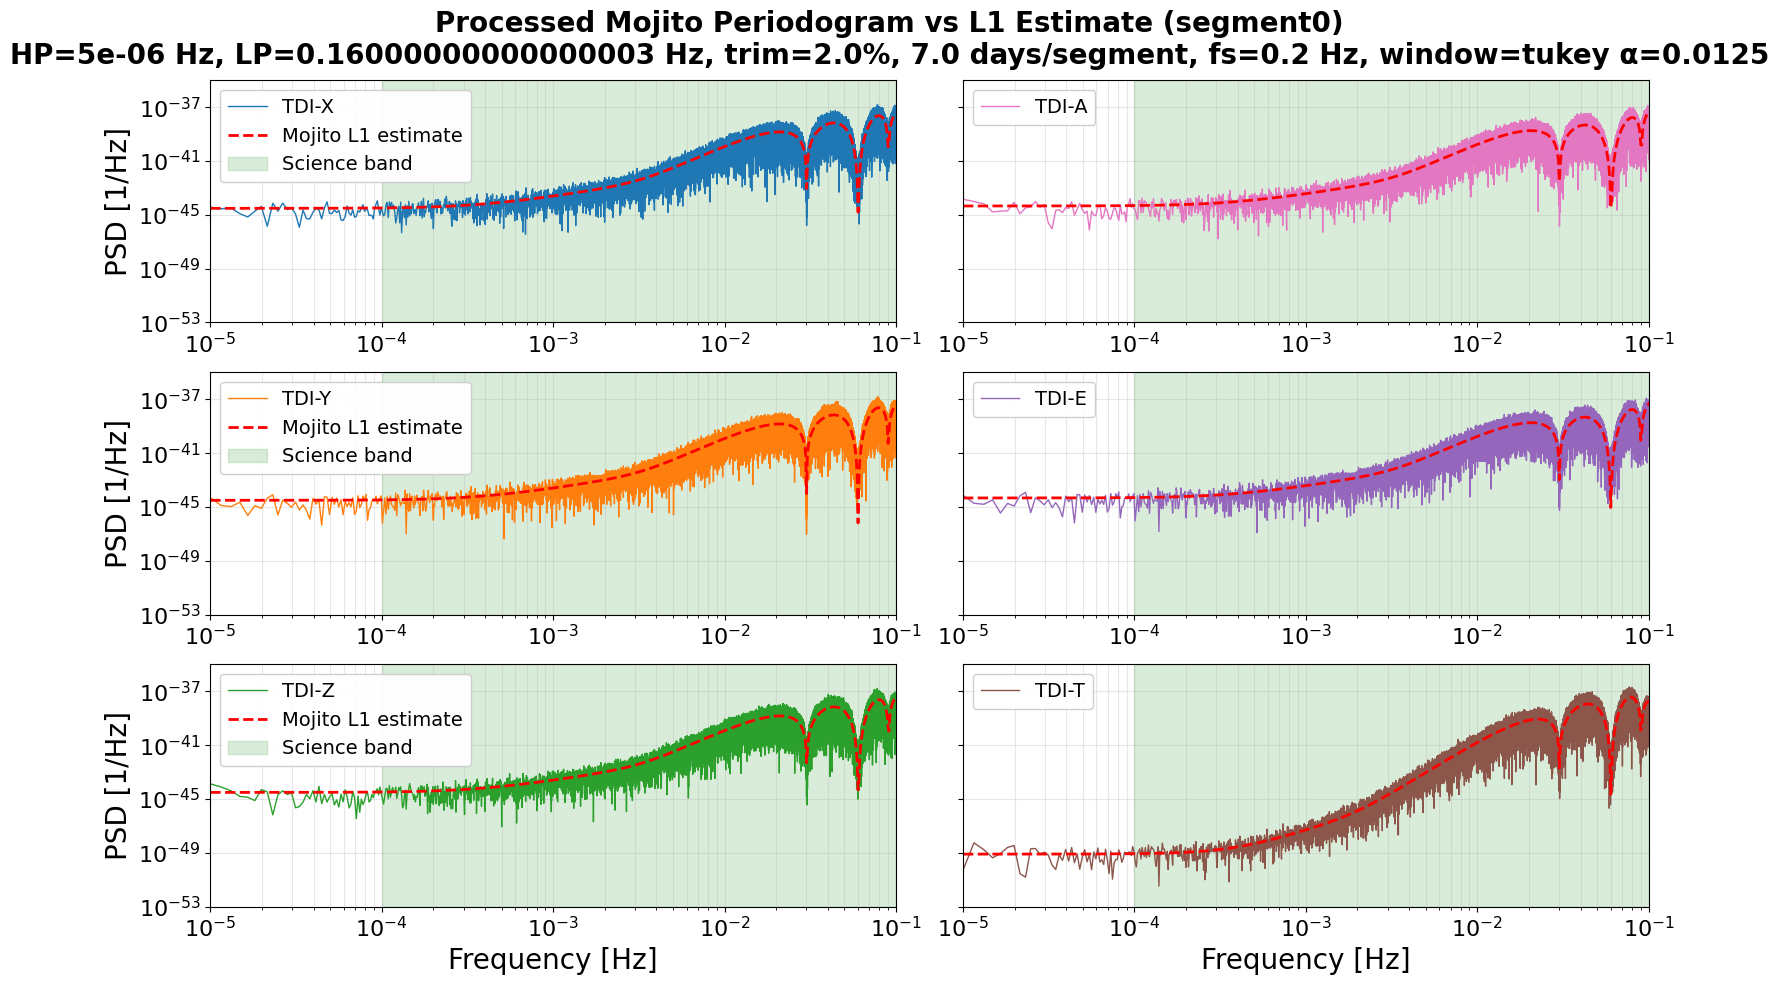

In [7]:
nyquist = sp_0.fs / 2
xyz_colors = ["C0", "C1", "C2"]
aet_colors = ["#e377c2", "#9467bd", "#8c564b"]

fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=False, sharey=True)

for i, ch in enumerate(["X", "Y", "Z"]):
    ax = axes[i, 0]
    ax.loglog(
        freq[1:],
        pgram_xyz[ch][1:],
        linewidth=1.0,
        color=xyz_colors[i],
        label=f"TDI-{ch}",
    )
    ax.loglog(
        data.noise_freqs,
        l1_xyz[ch],
        linestyle="dashed",
        color="red",
        linewidth=2.0,
        label="Mojito L1 estimate",
    )
    ax.axvspan(1e-4, 1e-1, alpha=0.15, color="green", label="Science band")
    ax.set_xlim(1e-5, nyquist)
    ax.set_ylim(1e-53, 1e-35)
    ax.set_ylabel("PSD [1/Hz]", fontsize=20)
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(loc="upper left", fontsize=14, framealpha=0.95)
    ax.tick_params(axis="both", which="major", labelsize=16)
for i, ch in enumerate(["A", "E", "T"]):
    ax = axes[i, 1]
    ax.loglog(
        freq[1:],
        pgram_aet[ch][1:],
        linewidth=1.0,
        color=aet_colors[i],
        label=f"TDI-{ch}",
    )
    ax.loglog(
        data.noise_freqs, l1_aet[ch], linestyle="dashed", color="red", linewidth=2.0
    )
    ax.axvspan(1e-4, 1e-1, alpha=0.15, color="green")
    ax.set_xlim(1e-5, nyquist)
    ax.set_ylim(1e-53, 1e-35)
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(loc="upper left", fontsize=14, framealpha=0.95)
    ax.tick_params(axis="both", which="major", labelsize=16)

axes[2, 0].set_xlabel("Frequency [Hz]", fontsize=20)
axes[2, 1].set_xlabel("Frequency [Hz]", fontsize=20)

fig.suptitle(
    f"Processed Mojito Periodogram vs L1 Estimate (segment0)\n"
    f"HP={filter_kwargs['highpass_cutoff']:.0e} Hz, "
    f"LP={filter_kwargs['lowpass_cutoff']} Hz, "
    f"trim={trim_kwargs['fraction']:.1%}, "
    f"{truncate_kwargs['days']} days/segment, "
    f"fs={sp_0.fs} Hz, "
    f"window={window_kwargs['window']} α={window_kwargs.get('alpha', 'N/A')}",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()
plt.show()